# 0.0 Theory

## 0.9 Steps of the algorithm  
1. Configurating Neural Network Architecure so describing: 
* input size (how many features),   
* hidden layer sizes,   
* outputsize,  
* learning rate,  
* epochs,  
* batch size,  
* regularization,  
* activation function.  
2. Initialize weights using He for ReLU or Xavier for sigmoid and bias with small values to avoid dead neurons  
  
3. Making forward propagation to get predicted probabilities:
    * computing pre_activation $Z = W*A_{prev} + b$ for each layer 
    * applying activation function to get A.  
    * Store Z and A in cache for backpropagation  

4. Calculate loss:
    * Calculate cross-entropy loss  
    * Add L2 regularization penalty on all weights  
  
5. Backward propagation to get gradient for all parameters:
    * Compute gradient of loss  
    * Backproopagate error through each layer:  
        * Calculate gradinets for weights and biases  
        * Include l2 regularization term  
    * Use chain rule and cached Z/A values from forward pass.  
  
6. Parameter update, update weights and biases using gradient descent  
7. Traing on mini-batch  

# 1.0 Implementation of dataset and analyzes

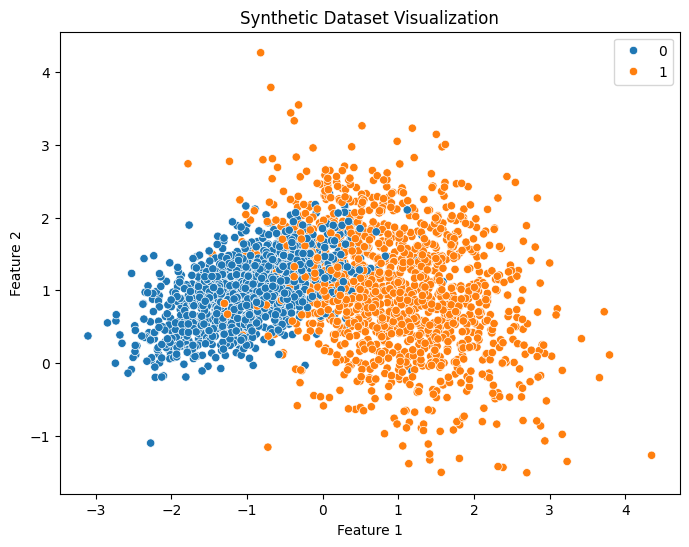

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, auc
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time

RANDOM_STATE = 254687
N_SAMPLES = 2587
N_FEATURES = 2
N_CLASSES = 2

class SyntheticDataset:
    """A class to generate and preprocess synthetic datasets for classification task."""

    def __init__(self, random_state: int, n_samples: int, n_features: int, n_classes: int, n_informative: int = N_FEATURES, n_clusters_per_class: int = 1, class_sep: float = 1):
        """
        Initialize the SyntheticDataset class.

        :param random_state: Seed for random number generation.
        :param n_samples: Number of samples to generate.
        :param n_features: Number of features for the dataset.
        :param n_classess: Number of classes for the target variable.
        """
        self.random_state = random_state
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_clusters_per_class = n_clusters_per_class
        self.class_sep = class_sep
        self.n_informative = n_informative
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None


    def generate_make_classification(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Generate a synthetic dataset using make_classification
        
        :return: A tuple containing the feature matrix (X) and target vector (y)
        """
        self.X, self.y = make_classification(
            n_samples=self.n_samples,
            n_features=self.n_features,
            n_informative=self.n_informative,
            n_redundant=0,
            n_clusters_per_class=self.n_clusters_per_class, # single-mod means one cluster per class
            random_state=self.random_state,
            class_sep=self.class_sep
            
        )
        return self.X, self.y
    
    def generate_make_moons(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Generate a synthetic dataset using make_mmons

        :return: A tuple containing the feature matrix (X) and target vector (y)
        """
        self.X, self.y = make_moons(
            n_samples=self.n_samples,
            random_state=self.random_state,
        )
        return self.X, self.y

    def normalize(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Normalize the feature matrix (X) and target vector(y) to the range [0,1].

        :return: A tuple containing the normalized feature matrix (X) and target vector (y)
 
        Note: 
        Remmber to fit only on training dataset so it means that I use min and max scaler on training dataset and
        then aplly this boudaries for test dataset. 
               """
        if self.X_train is not None and self.X_test is not None:
            min_x, max_x = self.X_train.min(), self.X_train.max() # Min, max taking only from training dataset
            self.X_train = (self.X_train - min_x) / (max_x - min_x)
            self.X_test = (self.X_test - min_x) / (max_x - min_x)

        return self.X_train, self.X_test 


    def visualize(self): 
        """ Visualize the dataset using a scatter plot"""
        if self.X is not None and self.y is not None:
            plt.figure(figsize=(8,6))
            sns.scatterplot(x=self.X[:,0], y=self.X[:,1], hue=self.y)
            plt.title("Synthetic Dataset Visualization")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.show()
        else:
            print("Dataset not generated yet. Call generate() first.")


    
    def splitting(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Function for splitting datasets into training and test"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=RANDOM_STATE)
        return self.X_train, self.X_test, self.y_train, self.y_test

    
dataset = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES, N_FEATURES)
dataset.generate_make_classification() 
dataset.visualize()

# Dividing dataset on a trening set and test set 
dataset.splitting()

# Normalization of datasets 
dataset.normalize()

class ResultsAnalyzes:
    """ 
    A class to analyze and visualize the results of a binary classification model.

    Parameters:
        target (np.ndarray): The true labels.
        prediction (np.ndarray): The predicted labels.
    """

    def __init__(self, target: np.ndarray, prediction: np.ndarray):
        self.target = target
        self.prediction = prediction
        self._accuracy = None # Private atribute
        self._sensitivity = None
        self._specificity = None
        self._precision = None
        self._false_match_rate = None
        self._false_non_match_rate = None

    def confusion_matrix(self):
        """ Compute and plot the confusion matrix """
        cm = confusion_matrix(self.target, self.prediction)

        # Plot the confusion matrix using Seaborn
        plt.figure(figsize=(6,4))
        sns.heatmap(
            cm, 
            annot=True, # Displays the value in each cell
            fmt="d", # Format the values as integers
            cmap="Blues", # uses a blue color palette 
            cbar=False, # Hide the color bar
            xticklabels=["Predcited 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"]
        )
        
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion matrix")
        plt.show()

    @property 
    def accuracy(self) -> float:
        """ 
        Compute the accuracy of the predictions.
        
        Notes:
            Tells how many samples were well classified from all samples
        """
        return accuracy_score(self.target, self.prediction) 

    @property
    def sensitivity(self) -> float: 
        """ 
        Compute the sensivitty (recall) of the predictions. Sensitivity (Recall) = TP / (TP + FN) 
        
        Notes:
            Tell how many samples were predicted as True Positive from all Acutal Positive
        """
        
        return recall_score(self.target, self.prediction)

    @property
    def specificity(self) -> float: 
        """
        Compute the specificity of the predictions.  Specificity = TN / (TN + FP)

        Notes:
            Tell how many samples were predicted as True Negatives from all Acutal Negative
        """
        
        cm = confusion_matrix(self.target, self.prediction)
        self.tn, self.fp, self.fn, self.tp = cm.ravel() # ravel function in numpy is used to faltten a multi-dimensional array into a 1-dimensional array. It returns a contiguous flattened array, meaning it 
        # collapses the array into a single dimension while maintaining the order of the elements 
        specificity = self.tn / (self.tn + self.fp)
        return specificity
    
    @property
    def balanced_accuracy(self) -> float:
        """
        Compute class imbalance by giving equal weight to both classes.

        Notes:  
         Useful when:
        - Model detects one class better than the other
        - Dataset has unequal class distribution

        !!!! high BA doesn't reveal if the model beats majority-class guessing
        example: in a 90% majority classs, BA = 0.9 could mean the model just predicts the majority that's why we need J score

        **Interpretation:**  
        - 1 = Perfect classifier  
        - 0.5 = Random guessing  
        
        """
        return (self.sensitivity + self.specificity) / 2
    
    @property
    def j_score(self) -> float:
        """
        Measures how much better the model is than random chance. Penalizes models that rely on class imbalance. 

        Notes:
        baseline = 0 means no better than guessing
        J = 0.6 means the model is 60% better than random
        J = -1 means always wrong
        J = 1 means perfect
        """
        return self.sensitivity + self.specificity - 1
    

    @property
    def f1_score(self) -> float:
        """
        Is a critical metric for evaluating classification models, especially when dealing with imbalanced datasets. 
        Penalizes models that ignore the minority class
        Use case: 
        Ideal for fraud detecion, disease screening:
        * In fraud detection: it answers: "Are we catching enough fraud without overwhelming our team?
        * In disease screening "Are we diagnosing patients early without causing unnecessary panic?
        """
        return f1_score(self.target, self.prediction)
    

    @property
    def false_match_rate(self) -> float:
        """
        This metric is critical in biometric systems (e.g., fingerprint, face recognition) and security applications. 
        Mistaking an impostor for a legitimate user.
        
        Notes:
        Lower FMR → Stricter system (fewer impostors accepted, but more legitimate users rejected).
        A bank vault prioritizes low FMR (avoid impostors) → High FNMR is tolerated (owners may retry).
        """
        return self.fp / (self.fp + self.tn)
    

    @property
    def false_non_match_rate(self) -> float:
        """
        This metric is critical in biometric systems (e.g., fingerprint, face recognition) and security applications. 
        Mistaking a legitimate user for an impostor. \
        
        Notes:
        A office door prioritizes low FNMR (avoid frustrating employees) → Higher FMR risk.       
        """
        return self.fn / (self.fn + self.tp)
    

    def show_results(self):
        """ Display the accuracy, sensitivity and specificity of the predictions"""
        #self.accuracy = self._accuracy()
        #self.sensitivity = self._sensitivity()
        #self.specificity = self._specificity()
        print(f"Accuracy: {self.accuracy:.2f}, Sensivity: {self.sensitivity:.2f}, Specifity: {self.specificity:.2f}")

    
    def plot_ROC_curve(self, y_prediction_probability: np.ndarray):
        """
        Plot the Receiver Operaint Characteristic (ROC) curve.
        
        Parameters:
            y_prediction_probability (np.ndarray): The predicted probabilities for the positive class.
        """
        # Compute ORC curve and AUC
        fpr, tpr, thresholds = roc_curve(self.target, y_prediction_probability) # stands for False Positive Rate (1 - Specificity)  and True Positive Rate (Sensitivity)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC cruve (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characterstics Curve")
        plt.legend(loc="lower right")
        plt.show()

        def plot_decision_boundary(self, X: np.ndarray, y: np.ndarray):
            """
            Plot the decision boundary for a trained model.
            
            Parameters:
                X (np.ndarray): The feature matrix of shape (n_samples,n_features)
                y (np.ndarray): The target vector of shape (n_samples,).
            """

            if X.shape[1] != 2:
                raise ValueError("Decision boundary plotting is only supported for 2D feature spaces.")
            
            # Create a grid of points covering the feature space
            x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1 # Frist feature
            y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1 # Second feature

# 2.0 Implementation of Neural Network

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
from dataclasses import dataclass

RANDOM_STATE = 254687

@dataclass
class NeuralNetworkConfig:
    """
    Configuration class for the neural network hyperparameters.

    Attributes:
        input_size (int): Number of input features
        hidden_sizes (List[int]): List of sizes for hidden layers.
        output_size (int): Number of output units.
        learning_rate (float): Learning rate for gradient descent
        epochs (int): Number of training iterations.
        batch_size (int) : Size of mini-batches for training.
        regularization (float): L2 regularization parameter
        activation (str): Activation function to use ('ReLu', 'sigmoid')
        random_seed (Optional[int]): Random seed for reproducibility
    """
    input_size: int
    hidden_sizes: List[int]
    output_size: int
    learning_rate: float = 0.01
    epochs: int = 1000
    batch_size: int = 32
    regularization: float = 0.001
    activation: str = 'ReLu'
    random_seed: Optional[int] = RANDOM_STATE


class NeuralNetwork:
    """A neural network implementation"""

    def __init__(self, config: NeuralNetworkConfig):
        """
        Initialize the neural network with given configuraion
        
        Args:
            config: NeuralNetworkConfig obcject cotaninig hyperparameters
        """

        self.config = config
        self.parameters = self._initialize_parameters()
        self.loss_history = []
        self.accuracy_history = []

    
    def _initialize_parameters(self) -> dict:
        """
        Initialize weights and biases for all layers using He initialization for ReLu or Xavier for sigmoid.

        Returns:
            Dictionniary coontainig initalized parameters (weights and biases)
        """
        layers_sizes = [self.config.input_size] + self.config.hidden_sizes + [self.config.output_size]
        parameters = {}

        for layer in range(1, len(layers_sizes)):
            # Initialization based on activation function
            if self.config.activation == "ReLu":
                scale = np.sqrt(2. / layers_sizes[layer - 1]) # He initialization
            else:
                scale = np.sqrt(1. / layers_sizes[layer - 1]) # Xavier initialization

            parameters[f'W{layer}'] = np.random.rand(layers_sizes[layer], layers_sizes[layer - 1]) * scale
            parameters[f'b{layer}'] = np.ones_like(layers_sizes[layer]) * 0.01

        return parameters
    

    def _activation(self, Z: np.ndarray, derivative: bool = False) -> np.ndarray:
        """
        Apply activation function to input.
        
        Args:
            Z: Input to activation function
            derivative: Whether to return derivative of activation
            
        Returns:
            Activated output or its derivative
        """
        if self.config.activation == 'sigmoid':
            if derivative:
                s = 1 / (1 + np.exp(-Z))
                return s * (1 - s)
            return 1 / (1 + np.exp(-Z))
        else:  # Default to ReLU
            if derivative:
                return (Z > 0).astype(float)
            return np.maximum(0, Z)
        
    def _output_activation(self, Z: np.ndarray, derivative: bool = False) -> np.ndarray:
        """
        Apply softmax activation for output layer (for multi-class classification).
        
        Args:
            Z: Input to softmax function
            derivative: Whether to return derivative (not used in this implementation)
            
        Returns:
            Softmax activated output
        """
        # Numerically stable softmax
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_Z / exp_Z.sum(axis=0, keepdims=True)
        
    
    def _forward_propagation(self, X: np.ndarray) -> Tuple[np.ndarray, dict]:
        """
        Perform forward propagation through the network.
        
        Args:
            X: input data

        Returns:
            Tuple of (output probabilities, cache of intermediate values)
        """
        cache = {'A0': X}
        A_prev = X

        # Hidden layers ofrward pass
        for layer in range(1, len(self.config.hidden_sizes) + 1):
            W = self.parameters[f'W{layer}']
            b = self.parameters[f'b{layer}']
            Z = np.dot(W, A_prev) + b
            A = self._activation(Z)

            cache[f'Z{layer}'] = Z
            cache[f'A{layer}'] = A
            A_prev = A

        # Output layer forward pass
        W_out = self.parameters[f'W{len(self.config.hidden_sizes) + 1}']
        b_out = self.parameters[f'b{len(self.config.hidden_sizes) + 1}']
        Z_out = np.dot(W_out, A_prev) + b_out
        A_out = self._output_activation(Z_out)

        cache[f'Z{len(self.config.hidden_sizes) + 1}'] = Z_out
        cache[f'A{len(self.config.hidden_sizes) + 1}'] = A_out

        return A_out, cache
    

    def _compute_loss(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        """
        Compute cross-entropy loss with L2 regularization.
        
        Args:
            Y_hat: Predicted probabilities
            Y: True labels (one-hot encoded)
            
        Returns:
            Computed loss value
        """
        m = y.shape[1]
        cross_entropy = -np.sum(y * np.log(y_hat + 1e-15)) / m  # Added epsilon for numerical stability
        
        # L2 regularization term
        l2_penalty = 0
        for layer in range(1, len(self.config.hidden_sizes) + 2): # Why + 2? Output layer and we started counting from 1
            l2_penalty += np.sum(np.square(self.parameters[f'W{layer}']))
            
        l2_penalty = (self.config.regularization / (2 * m)) * l2_penalty
        
        return cross_entropy + l2_penalty
    
    def _backward_propagation(self, Y: np.ndarray, cache: dict) -> dict:
        """
        Perform backward propagation to compute gradients.
        
        Args:
            Y: True labels (one-hot encoded)
            cache: Dictionary containing intermediate values from forward pass
            
        Returns:
            Dictionary containing gradients for each parameter
        """
        gradients = {}
        m = Y.shape[1]
        L = len(self.config.hidden_sizes) + 1  # Total layers (hidden + output)
        
        # Output layer gradient
        dZ = cache[f'A{L}'] - Y
        gradients[f'dW{L}'] = np.dot(dZ, cache[f'A{L-1}'].T) / m
        gradients[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True) / m
        
        # Add regularization term to weights
        gradients[f'dW{L}'] += (self.config.regularization / m) * self.parameters[f'W{L}']
        
        # Hidden layers gradients
        for l in reversed(range(1, L)):
            dA = np.dot(self.parameters[f'W{l+1}'].T, dZ)
            dZ = dA * self._activation(cache[f'Z{l}'], derivative=True)
            
            gradients[f'dW{l}'] = np.dot(dZ, cache[f'A{l-1}'].T) / m
            gradients[f'db{l}'] = np.sum(dZ, axis=1, keepdims=True) / m
            
            # Add regularization term to weights
            gradients[f'dW{l}'] += (self.config.regularization / m) * self.parameters[f'W{l}']
            
        return gradients
    
    def _update_parameters(self, gradients: dict):
        """
        Update network parameters using gradient descent.
        
        Args:
            gradients: Dictionary containing gradients for each parameter
        """
        for l in range(1, len(self.config.hidden_sizes) + 2):
            self.parameters[f'W{l}'] -= self.config.learning_rate * gradients[f'dW{l}']
            self.parameters[f'b{l}'] -= self.config.learning_rate * gradients[f'db{l}']
    
    def _compute_accuracy(self, Y_hat: np.ndarray, Y: np.ndarray) -> float:
        """
        Compute classification accuracy.
        
        Args:
            Y_hat: Predicted probabilities
            Y: True labels (one-hot encoded)
            
        Returns:
            Accuracy score between 0 and 1
        """
        predictions = np.argmax(Y_hat, axis=0)
        labels = np.argmax(Y, axis=0)
        return np.mean(predictions == labels)
    
    def train(self, X_train: np.ndarray, Y_train: np.ndarray) -> dict:
        """
        Train the neural network using mini-batch gradient descent.
        
        Args:
            X_train: Training features (n_features, n_samples)
            Y_train: Training labels (one-hot encoded)
            
        Returns:
            Dictionary containing training history
        """
        m = X_train.shape[1]
        num_batches = m // self.config.batch_size
        
        for epoch in range(self.config.epochs):
            # Shuffle training data
            permutation = np.random.permutation(m)
            X_shuffled = X_train[:, permutation]
            Y_shuffled = Y_train[:, permutation]
            
            for i in range(num_batches):
                # Get mini-batch
                start = i * self.config.batch_size
                end = start + self.config.batch_size
                X_batch = X_shuffled[:, start:end]
                Y_batch = Y_shuffled[:, start:end]
                
                # Forward and backward pass
                Y_hat, cache = self._forward_propagation(X_batch)
                gradients = self._backward_propagation(Y_batch, cache)
                self._update_parameters(gradients)
            
            # Compute and store loss and accuracy
            Y_hat_train, _ = self._forward_propagation(X_train)
            train_loss = self._compute_loss(Y_hat_train, Y_train)
            train_acc = self._compute_accuracy(Y_hat_train, Y_train)
            
            self.loss_history.append(train_loss)
            self.accuracy_history.append(train_acc)
            
            
            # Print progress
            if epoch % 100 == 0 or epoch == self.config.epochs - 1:
                print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}")
        
        return {
            'loss_history': self.loss_history,
            'accuracy_history': self.accuracy_history
        }
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions for input data.
        
        Args:
            X: Input data (features)
            
        Returns:
            Predicted class probabilities
        """
        Y_hat, _ = self._forward_propagation(X)
        return Y_hat
    

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Return probabilities in scikit-learn format (n_samples, n_features)"""
        return self.predict(X).T
    

    def predict_classes(self, X: np.ndarray) -> np.ndarray:
        """Return class labels (n_samples, )"""
        return np.argmax(self.predict_proba(X), axis=1)
    
    def plot_training_history(self):
        """
        Plot training loss and accuracy history.
        """
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_history)
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.tight_layout()
        plt.show()

   

# 3.0 Creating dataset

In [70]:
N_CLUSTERS_PER_CLASS = 3
CLASS_SEP = 2.0
N_INFORMATIVE = 3
N_FEATURES = 3
dataset_multimodal = SyntheticDataset(RANDOM_STATE, N_SAMPLES, N_FEATURES, N_CLASSES, N_INFORMATIVE, N_CLUSTERS_PER_CLASS, CLASS_SEP)
dataset_multimodal.generate_make_classification() 

# Dividing dataset on a trening set and test set 
dataset_multimodal.splitting()

# Normalization of datasets 
dataset_multimodal.normalize()

(array([[0.71224629, 0.34420487, 0.75591848],
        [0.72012904, 0.45776158, 0.62159135],
        [0.34024436, 0.56406395, 0.5479759 ],
        ...,
        [0.50899928, 0.65925058, 0.42328158],
        [0.32606996, 0.56206274, 0.29785085],
        [0.27964085, 0.653018  , 0.3243969 ]], shape=(2069, 3)),
 array([[0.40762072, 0.48216904, 0.55533435],
        [0.76525644, 0.66411427, 0.39494654],
        [0.59171867, 0.59024718, 0.24862742],
        ...,
        [0.24204414, 0.6308155 , 0.2486396 ],
        [0.28162635, 0.52246802, 0.5684254 ],
        [0.6798244 , 0.52777402, 0.61784361]], shape=(518, 3)))

# 4.0 Applying model

Epoch 0: Train Loss = 0.7240, Train Acc = 0.5051
Epoch 100: Train Loss = 0.4232, Train Acc = 0.8212
Epoch 200: Train Loss = 0.2984, Train Acc = 0.8772
Epoch 300: Train Loss = 0.1833, Train Acc = 0.9319
Epoch 400: Train Loss = 0.1752, Train Acc = 0.9357
Epoch 499: Train Loss = 0.1680, Train Acc = 0.9391


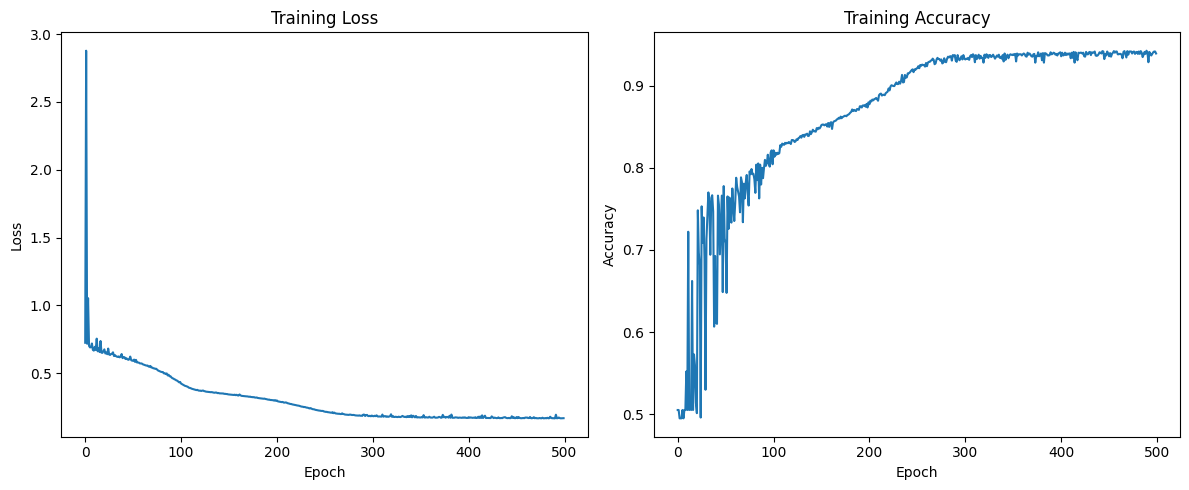

Algoritm model took 0.06s


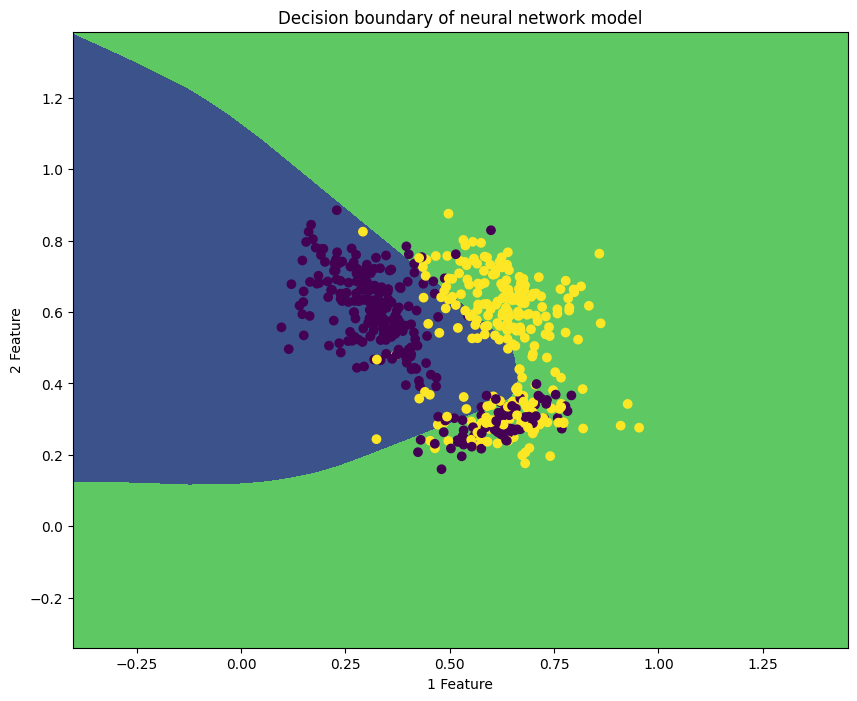

Accuracy: 0.95, Sensivity: 0.94, Specifity: 0.96


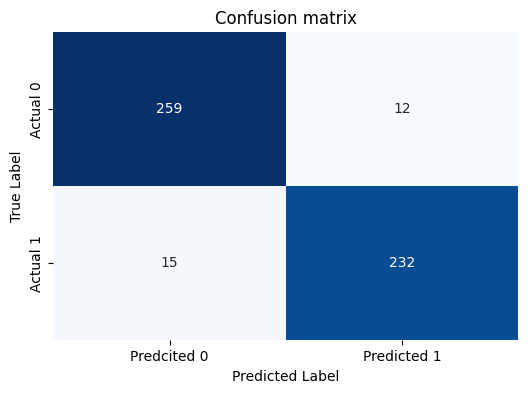

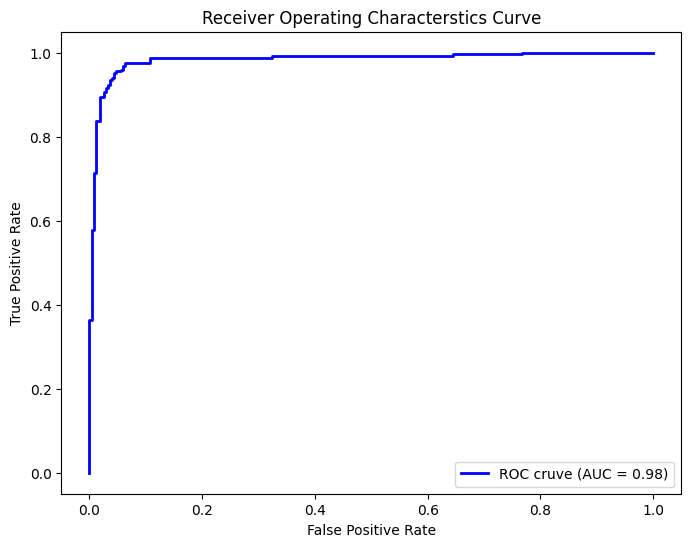

In [76]:
config = NeuralNetworkConfig(
    input_size=3,  # 3 input features
    hidden_sizes=[128, 64, 32],  # 3 hidden layers
    output_size=2,  # 2 classes 
    learning_rate=0.01,
    epochs=500,
    batch_size=64,
    regularization=0.001,
    activation='relu',
    random_seed=RANDOM_STATE
)

# Create and train network
nn = NeuralNetwork(config)

X_train = dataset_multimodal.X_train.T
Y_train = dataset_multimodal.y_train
Y_train = np.eye(config.output_size)[Y_train].T  # One-hot encode, required for cross-entropy 

# Train the network
history = nn.train(X_train, Y_train)

# Plot training history
nn.plot_training_history()

X_test = dataset_multimodal.X_test.T



# Computing time
start_time = time.time()

for _ in range(100):

    y_pred = nn.predict_classes(X_test)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Algoritm model took {elapsed_time:.2f}s")

y_score = nn.predict_proba(dataset_multimodal.X_test.T)[:,1]

# Chosing to visualize 2 features (features 0 and 1)
feature_x = 0
feature_y = 1
fixed_feature = dataset_multimodal.X_train[:,2].mean()

# Creating meshgrid
x_min, x_max = dataset_multimodal.X_test[:,feature_x].min() - 0.5, dataset_multimodal.X_test[:,feature_x].max() + 0.5
y_min, y_max = dataset_multimodal.X_test[:,feature_y].min() - 0.5, dataset_multimodal.X_test[:,feature_y].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

grid = np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, fixed_feature)]

Z = nn.predict_proba(grid.T)[:,1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1])
plt.scatter(dataset_multimodal.X_test[:,0], dataset_multimodal.X_test[:,1], c=dataset_multimodal.y_test)
plt.xlabel("1 Feature")
plt.ylabel("2 Feature")
plt.title("Decision boundary of neural network model")
plt.show()

linear_sklearn_analyzer = ResultsAnalyzes(dataset_multimodal.y_test, y_pred)
linear_sklearn_analyzer.show_results()
linear_sklearn_analyzer.confusion_matrix()
linear_sklearn_analyzer.plot_ROC_curve(y_score)